In [486]:
# import modules
from dotenv import load_dotenv, find_dotenv
import tweepy
import pandas as pd
import numpy as np
import os
import re

import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")
import seaborn as sns
from collections import Counter

import matplotlib.pyplot as plt; plt.rcdefaults()

# nltk 
from nltk.stem.snowball import SnowballStemmer 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# sentimental analisys
from textblob import TextBlob

# roBERTa-base for Sentiment Analysis
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax

# load model and tokenizet
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

load_dotenv(find_dotenv())

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


True

In [487]:
# set online authentication
auth = tweepy.OAuth1UserHandler(os.getenv('consumer_key'), os.getenv('consumer_secret'))
auth.set_access_token (os.getenv('access_token'), os.getenv('access_token_secret'))

# seting up Oauth 2.0 Bearer Token
#auth = tweepy.OAuth2BearerHandler(os.getenv('bearer_token'))

# calling the API
api = tweepy.API(auth)

In [488]:
screen_name = "elonmusk"

# Returns information about the specified user
user = api.get_user(screen_name = screen_name)


In [489]:
# printing the information
print("The id is : " + str(user.id))
print("The id_str is : " + user.id_str)
print("The name is : " + user.name)
print("The screen_name is : " + user.screen_name)
print("The location is : " + str(user.location))
print("The profile_location is : " + str(user.profile_location))
print("The description is : " + user.description)

The id is : 44196397
The id_str is : 44196397
The name is : Elon Musk
The screen_name is : elonmusk
The location is : 
The profile_location is : None
The description is : Mars & Cars, Chips & Dips


In [490]:
# use lowercases for search term
screen_name = 'elonmusk'
search_term = 'biden reelection'
tweet_amount = 500
tweets_raw = []
likes = []
time = []

# return most recent status posted
# search by user name
'''
data = tweepy.Cursor(api.user_timeline,
                       screen_name = screen_name,
                       tweet_mode='extended',
                       ).items(tweet_amount)


# return most recent search word
'''
# search by topic
data = tweepy.Cursor(api.search_tweets,
                       q = search_term,
                       lang='en',
                       tweet_mode='extended',
                       ).items(tweet_amount)


# getting data into a lists
for tweet in data:
    #print(tweet.text)
    tweets_raw.append(tweet.full_text)
    likes.append(tweet.favorite_count)
    time.append(tweet.created_at)


In [491]:
type(tweets_raw)

list

In [492]:
# cleaning tweets, removing mentioned users (@)

tweets_final = []

for tweet in tweets_raw:
    final_text = tweet.replace('&amp;', 'and')
    #final_text = re.sub('^RT ', '', final_text)      # this remove only RT letters
    final_text = re.sub('htt.*', 'http', final_text)
    final_text = re.sub(r'@.\w+', '@user ', final_text)
    tweets_final.append(final_text)


# create data frame
df = pd.DataFrame({'tweets':tweets_final,'likes':likes,'time':time})

# removing retweets (all the line)
df = df[~df.tweets.str.contains("RT")]

# removing links
#df = df[~df.tweets.str.contains("http")]

# reset index
df = df.reset_index(drop=True)

# fb to a list
list_of_sentences = [sentence for sentence in df.tweets]


list_of_sentences[0]

'@user  This is a hitman a "chayotero" who is paid by Open Society. He speaks on behalf of organized crime supported by Soros and Biden Administration. He and his narrative are useless, irrelevant for salvadorean citizens ready for Bukele reelection. 😂🤣😭'

In [493]:
score_Negative = []
score_Neutral = []
score_Positive = []

for tweets in list_of_sentences:

    # sentiment analysis
    encoded_tweet = tokenizer(tweets, return_tensors='pt')
    #output = model(encoded_tweet['input_ids'], encoded_tweet['attention_mask'])
    output = model(**encoded_tweet)

    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    score_Negative.append(scores[0]) 
    score_Neutral.append(scores[1]) 
    score_Positive.append(scores[2]) 


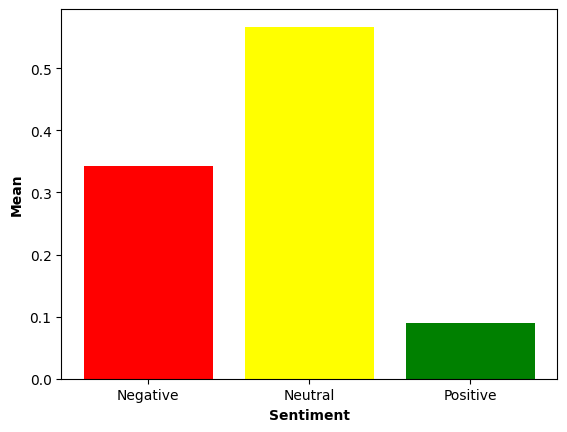

In [494]:
df =pd.DataFrame({'tweets': list_of_sentences, 'negative': score_Negative, 'neutral': score_Neutral, 'positive': score_Positive,})

# Define Data 
lables = ['Negative', 'Neutral', 'Positive']
score_means = [df["negative"].mean(), df["neutral"].mean(), df["positive"].mean()]

# Plot bar chart
plt.bar(lables, score_means, color=['red', 'yellow', 'green'])
plt.xticks()
plt.xlabel("Sentiment", fontweight='bold')
plt.ylabel("Mean", fontweight='bold')

plt.show()

In [495]:
# Roberta Sentiment Analysis

tweets_proc = []
tweet_words = []
tweets_scores = []

tweets_test = list_of_sentences[46]
lables = ['Negative', 'Neutral', 'Positive']


for word in tweets_test.split(' '):
    if word.startswith('@') and len(word) > 1:
        word = '@user'

    elif word.startswith('http'):
        word = 'http'
    tweet_words.append(word)

tweet_proc = " ".join(tweet_words)
#tweets_proc.append(tweet_proc)

print(tweet_proc)

# sentiment analysis
encoded_tweet = tokenizer(tweet_proc, return_tensors='pt')
#output = model(encoded_tweet['input_ids'], encoded_tweet['attention_mask'])
output = model(**encoded_tweet)


scores = output[0][0].detach().numpy()
scores = softmax(scores)

# tweets_scores.append(scores)


for i in range(len(scores)):

     l = lables[i]
     s = scores[i]
     print(l,s)



Karl Rove on Biden's chances of reelection in 2024: 'Zero' http
Negative 0.09331326
Neutral 0.85905755
Positive 0.047629297


In [496]:
tweets_proc

[]

In [497]:
# cleaning tweets, removing mentioned users (@)

tweets_final = []

for tweet in tweets_raw:
    final_text = tweet.replace('&amp;', 'and')
    #final_text = re.sub('^RT ', '', final_text)      # this remove only RT letters
    final_text = re.sub('htt.*', '', final_text)


    while final_text.startswith('@'):
            position = final_text.index(' ')
            final_text = final_text[position+1:]        

    #print(final_text)
    tweets_final.append(final_text)


In [498]:
# create data frame
df = pd.DataFrame({'tweets':tweets_final,'likes':likes,'time':time})

# removing retweets (all the line)
df = df[~df.tweets.str.contains("RT")]

# removing links
#df = df[~df.tweets.str.contains("http")]

# reset index
df = df.reset_index(drop=True)

# most like tweetsmostlike = df.loc[df.likes.nlargest(10).index]

In [499]:
# fb to a list
list_of_sentences = [sentence for sentence in df.tweets]

lines = []
for sentence in list_of_sentences:
    words = sentence.split()
    for w in words:
        lines.append(w)

In [500]:
list_of_sentences

['This is a hitman a "chayotero" who is paid by Open Society. He speaks on behalf of organized crime supported by Soros and Biden Administration. He and his narrative are useless, irrelevant for salvadorean citizens ready for Bukele reelection. 😂🤣😭',
 "can not say he will not run for reelection because that'll make him a lame duck President instantly yet Democrats getting railroaded on Nov 8, 2022 will do the same thing. Once GOP captures the House and/or the Senate on Nov 8, Biden Presidency will be effectively over. ",
 'Biden hangs on to reelection hopes, but troubles mount against him | Bill Cotterell ',
 "you know what's gonna be weird is when Biden wins reelection",
 'Joe represents a state where Trump single handily Beat Joe Biden so he’s doing what’s best for his constituents so he doesn’t lose his job the next time he’s up for reelection',
 'Biden is a great guy, but we need a great leader. Biden should hold true to his promise of a bridge / transitional presidency and announc

10.778483044733044
57
23
77


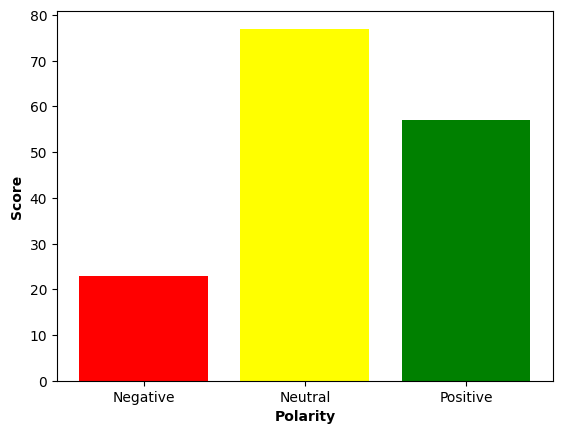

In [501]:
## sentiment analysis 
polarity = 0

positive = 0
neutral = 0
negative = 0

for raw_text in df.tweets:
    analysis = TextBlob(raw_text)
    tweet_polarity = analysis.polarity
    if tweet_polarity > 0.00:
        positive += 1
    elif tweet_polarity < 0.00:
        negative += 1
    elif tweet_polarity == 0.00:
        neutral += 1
    polarity += tweet_polarity


print(polarity)
print(positive)
print(negative)
print(neutral)

# Define Data 
lables = ['Negative', 'Neutral', 'Positive']
polarity_score = [negative, neutral, positive]

# Plot bar chart
plt.bar(lables, polarity_score, color=['red', 'yellow', 'green'])
plt.xticks()
plt.xlabel("Polarity", fontweight='bold')
plt.ylabel("Score", fontweight='bold')

plt.show()

In [502]:
# remove punctuaction
lines2 = []

# if it is a currency amount keeps the format
for x in lines:
    if x[0] == '$' and x[1].isdigit():
        lines2.append(x)
    else:
        temp = re.sub(r'[^A-Za-z0-9]+', '', x)
        lines2.append(temp)


# remove empty objects
lines3 = []

for word in lines2:
    if word != '':
        lines3.append(word)


In [503]:
lines3

['This',
 'is',
 'a',
 'hitman',
 'a',
 'chayotero',
 'who',
 'is',
 'paid',
 'by',
 'Open',
 'Society',
 'He',
 'speaks',
 'on',
 'behalf',
 'of',
 'organized',
 'crime',
 'supported',
 'by',
 'Soros',
 'and',
 'Biden',
 'Administration',
 'He',
 'and',
 'his',
 'narrative',
 'are',
 'useless',
 'irrelevant',
 'for',
 'salvadorean',
 'citizens',
 'ready',
 'for',
 'Bukele',
 'reelection',
 'can',
 'not',
 'say',
 'he',
 'will',
 'not',
 'run',
 'for',
 'reelection',
 'because',
 'thatll',
 'make',
 'him',
 'a',
 'lame',
 'duck',
 'President',
 'instantly',
 'yet',
 'Democrats',
 'getting',
 'railroaded',
 'on',
 'Nov',
 '8',
 '2022',
 'will',
 'do',
 'the',
 'same',
 'thing',
 'Once',
 'GOP',
 'captures',
 'the',
 'House',
 'andor',
 'the',
 'Senate',
 'on',
 'Nov',
 '8',
 'Biden',
 'Presidency',
 'will',
 'be',
 'effectively',
 'over',
 'Biden',
 'hangs',
 'on',
 'to',
 'reelection',
 'hopes',
 'but',
 'troubles',
 'mount',
 'against',
 'him',
 'Bill',
 'Cotterell',
 'you',
 'know',


In [504]:
# stemming the words to their word root
s_wnl = WordNetLemmatizer()
s_stemmer = SnowballStemmer(language='english')

stem = []

for word in lines3:
    s_wnl.lemmatize(word) if s_wnl.lemmatize(word).endswith('e') else s_stemmer.stem(word)
    stem.append(word)
    #stem.append(s_wnl.lemmatize(word))
    

In [505]:
# remov all stop words
stop_words = set(stopwords.words("english"))
stem2 = []

for word in stem:
    if word.casefold() not in stop_words:
        stem2.append(word)


In [506]:
# delete all x elements from a list and the search words
search_split = search_term.split()

# add words to remove
to_delete = ['im']

delete_list = to_delete + search_split
new_list = []

for word in stem2:
    if word.casefold() not in delete_list:
        new_list.append(word)


In [507]:
#new_list

In [508]:
df = pd.DataFrame(new_list)

# make all lowercase
df = df.applymap(lambda s:s.lower() if type(s) == str else s)

# group the words
df = df[0].value_counts()

In [509]:
# frecuencies of the words
freqdoctor = FreqDist()

for words in df:
    freqdoctor[words] += 1

freqdoctor

FreqDist({1: 624, 2: 142, 3: 62, 4: 59, 5: 26, 6: 13, 8: 10, 7: 8, 9: 4, 23: 3, ...})

c:\Users\imont\anaconda3\envs\django2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


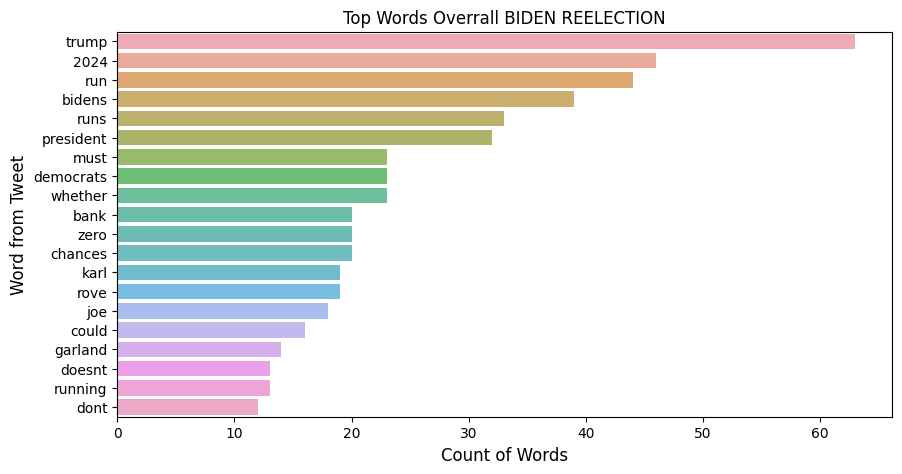

In [510]:
# simple plot that shows the top 20 words being used

df = df[:20]
plt.figure(figsize=(10,5))
sns.barplot(df.values, df.index, alpha=0.8)
plt.title('Top Words Overrall ' + search_term.upper())
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()

In [511]:
def show_ents(doc):
    if doc.ents:
        for ent in doc.ents:
            print(ent.text +  ' - ' + ent.label_ + ' - ' + str(spacy.explain(ent.label)))

In [512]:
str1 = " "
stem2 = str1.join(lines2)

stem2 = nlp(stem2)

label = [(X.text, X.label_) for X in stem2.ents]

df6 = pd.DataFrame(label, columns = ['Word', 'Entity'])

df7 = df6.where(df6['Entity'] == 'ORG')

df7 = df7['Word'].value_counts()


c:\Users\imont\anaconda3\envs\django2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


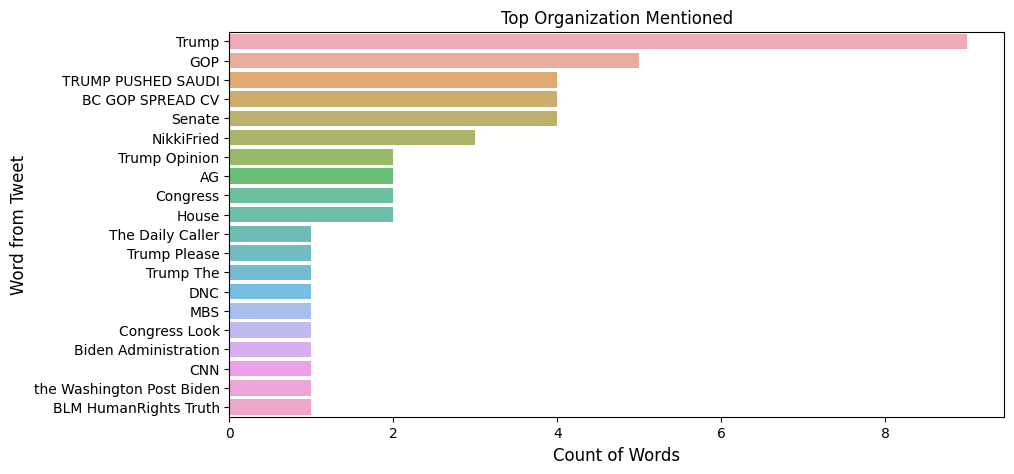

In [513]:
# simple plot that shows the top organiations

df = df7[:20]
plt.figure(figsize=(10,5))
sns.barplot(df.values, df.index, alpha=0.8)
plt.title('Top Organization Mentioned')
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()

In [514]:
# top persons he is talking aobut

str1 = " "
stem2 = str1.join(lines2)

stem2 = nlp(stem2)

label = [(X.text, X.label_) for X in stem2.ents]

df6 = pd.DataFrame(label, columns = ['Word', 'Entity'])

df7 = df6.where(df6['Entity'] == 'PERSON')

df7 = df7['Word'].value_counts()

c:\Users\imont\anaconda3\envs\django2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


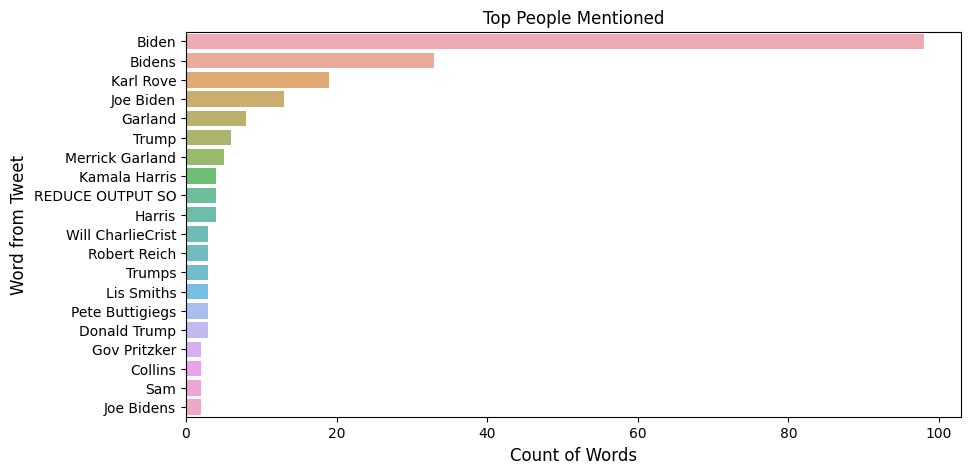

In [515]:
# simple plot that shows the top people mentioned

df = df7[:20]
plt.figure(figsize=(10,5))
sns.barplot(df.values, df.index, alpha=0.8)
plt.title('Top People Mentioned')
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()